Mode decomposition of emotional arcs!
----------------------------------------------

This second version uses only the linear algebra version of the SVD.

In [1]:
from os import listdir, mkdir
from os.path import isfile, join, isdir
from json import loads
from re import findall,UNICODE
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *
from bookclass import *

from tqdm import tqdm

In [2]:
# all our essentials
from matplotlib import rc,rcParams
rc('font', family='sans-serif') 
rc('font', serif='Helvetica Neue')
rc('text', usetex='false')

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='true')
# this should accomplish the same thing
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{hyperref}'
rcParams['text.latex.unicode'] = True

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

# import matplotlib
# matplotlib.use("pgf")
# pgf_with_custom_preamble = {
#     "text.usetex": True,
#     "text.latex.unicode": True,
#     "pgf.preamble": [
#         r"\usepackage{hyperref}"
#         ]
# }
# matplotlib.rcParams.update(pgf_with_custom_preamble)
# matplotlib.rcParams.update({'font.size': 12})
# from matplotlib import pyplot as plt

In [3]:
from sklearn import metrics
from sklearn.cluster import KMeans
# from the demo
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.preprocessing import scale

In [4]:
filters = {"min_dl":40,
           "length": [20000,100000],
           "P": True,
           "n_points": 200,
           "salad": False,
          }

In [5]:
q = get_books(Book,filters)

In [6]:
len(q)

1385

In [7]:
f = open("../media/paper/emotional-arcs.nbooks.tex","w")
f.write("\\newcommand{{\\nbooks}}{{{0:,}}}".format(len(q)))
f.close()

In [8]:
version_str = get_version_str(filters)

In [9]:
version_str

'P-20K-100K-40dl-200pt'

In [10]:
this_dir = join("../media/figures/SVD",version_str)
if not isdir(this_dir):
    mkdir(this_dir)

In [11]:
data = get_data(q,version_str,filters,use_cache=True)

In [12]:
# for i in range(len(data[:,0])):
#     if np.isnan(data[i,:]).any():
#         print(q[i].title,q[i].length,q[i].gutenberg_id)
#         print(i)
#         print(np.where(np.isnan(data[i,:])))
#         b = Book_raw_data(q[i])
#         b.chopper_sliding(my_LabMT,num_points=200,stop_val=1.0,use_cache=True)
#         print(len(b.all_word_list))
#         # print(b.all_word_list)
#         # print(b.chunks_nlp)
#         # print(b.all_word_list[-100:])
#         # print(b.centers)
#         # print(b.timeseries)
#         print(np.where(np.isnan(b.timeseries)))
#         # print(b.all_fvecs.sum(axis=1))
#         data[i,:] = b.timeseries
#         save_book_raw_data(b)
# for i in [3762,3804,3827,3910,3926]:
#     print(q[i].title,q[i].length)
#     print(i)
#     # print(np.where(np.isnan(data[i,:])))
#     b = Book_raw_data(q[i])
#     b.chopper_sliding(my_LabMT,num_points=200,stop_val=1.0,use_cache=False)
#     print(np.where(np.isnan(b.timeseries)))
#     print(len(b.all_word_list))
#     print(b.this_Book.title)
#     b = Book_raw_data(q[i])
#     b.chopper_sliding(my_LabMT,num_points=200,stop_val=1.0,use_cache=False)
#     print(np.where(np.isnan(b.timeseries)))
#     print(len(b.all_word_list))
#     print(b.this_Book.title)
#     b = Book_raw_data(q[i])
#     b.chopper_sliding(my_LabMT,num_points=200,stop_val=1.0,use_cache=False)
#     print(np.where(np.isnan(b.timeseries)))
#     print(len(b.all_word_list))
#     print(b.this_Book.title)
#     b = Book_raw_data(q[i])
#     b.chopper_sliding(my_LabMT,num_points=200,stop_val=1.0,use_cache=False)
#     print(np.where(np.isnan(b.timeseries)))
#     print(len(b.all_word_list))
#     # print(b.all_fvecs.sum(axis=1))

In [13]:
assert len(q) == data.shape[0]
print(len(q))

1385


In [14]:
# this way takes the mean of all stories out
# big_matrix_mean0 = big_matrix-big_matrix.mean(axis=0)
# but I should do it individually...
# (not going to normalize, either)
# this is a really ugly way to do that:
big_matrix_mean0 = data-np.tile(data.mean(axis=1),(200,1)).transpose()

In [15]:
U,S,V = np.linalg.svd(big_matrix_mean0,full_matrices=True,compute_uv=True)

In [16]:
pickle.dump(S,open(join(this_dir,"singular-values.p"),"wb"))

## Look at the books that have most variance explained by individual modes

Going to normalize first within each book so that the coefficients add to 1.

Choosing to do this in W (could also use U).

Just depends whether putting S into U or V (here, putting it into U).

In [17]:
w = U[:,:200]*S
w_abs = np.abs(w)
w_normalized = np.multiply(w,np.tile(1./w_abs.sum(axis=1),(200,1)).transpose())

In [18]:
w

array([[ -2.23241591e-01,   8.21177574e-02,  -9.32469392e-02, ...,
          8.13561838e-04,  -5.76420394e-03,   8.50857592e-15],
       [  8.87261403e-02,   2.12701338e-01,  -2.21473557e-01, ...,
         -2.09507741e-03,   5.29861358e-03,  -9.69805527e-15],
       [ -5.15754976e-01,  -8.02266777e-01,  -4.10666310e-01, ...,
          7.48817227e-03,   1.71242236e-03,   8.09155974e-15],
       ..., 
       [  3.94703326e-01,   6.74710691e-01,   6.25736174e-01, ...,
          2.54387844e-03,   9.90242353e-03,   3.49295268e-15],
       [  9.57160925e-01,  -3.05724340e-01,  -5.58756088e-01, ...,
         -4.59356715e-03,  -8.69680831e-03,   6.52393670e-15],
       [  2.97570622e-01,   1.08417041e+00,   2.86325661e-01, ...,
         -5.94801818e-03,  -2.07284450e-03,  -1.05073798e-14]])

34.8888463393
xwidth is 0.3
yheight is 0.22249999999999998


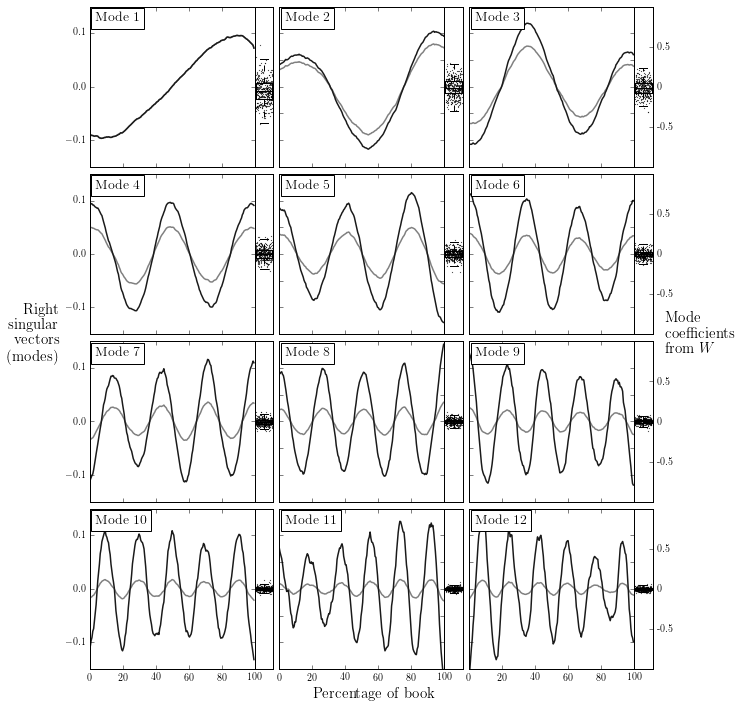

In [19]:
print(S[0])
num_x = 3
num_y = 12/num_x
xspacing = .01
yspacing = .01
xoffset = .07
yoffset = .07
xwidth = (1.-xoffset)/(num_x)-xspacing
yheight = (1.-yoffset)/(num_y)-yspacing
print('xwidth is {0}'.format(xwidth))
print('yheight is {0}'.format(yheight))
ylim = .15

fig = plt.figure(figsize=(8.5,10))
for i in range(12):
#         print(i)
#         print("====")
#         print((i-i%num_x))
    # ind = np.argsort(w[:,sv+svstart])[-20:]
    ax1rect = [xoffset+(i%num_x)*(xspacing+xwidth),1.-yheight-yspacing-(int(np.floor((i-i%num_x)/num_x))*(yspacing+yheight)),xwidth*.9,yheight]
    ax2rect = ax1rect.copy()
    ax2rect[0] += ax1rect[2]
    ax2rect[2] = (1-.9)*xwidth
    ax1 = fig.add_axes(ax1rect)
    ax2 = fig.add_axes(ax2rect)
    ax2.set_ylim([-1,1])
    ax2.set_xlim([.5,1.5])
    w_subset = np.random.choice(w_normalized[:,i],400)
    x_values = .55+.9*np.random.rand(400)
    ax2.scatter(x_values,
                w_subset,
                facecolor="k",
                edgecolor=None,
                linewidth=0.0,
                s=3.5,
                # edgewidth=0.0,
                alpha=0.1)
    ax2.scatter(x_values,
                w_subset,
                facecolor="k",
                edgecolor=None,
                linewidth=0.0,
                s=.7,
                # edgewidth=0.0,
                alpha=0.7)
#     p = [np.percentile(w_normalized[:,i],50),
#          np.percentile(w_normalized[:,i],50),
#          np.percentile(w_normalized[:,i],50)]
    boxprops = dict(linestyle='-', linewidth=1.0, color='k')
    medianprops = dict(linestyle='--', linewidth=1.0, color='k')
    # meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
    ax2.boxplot(w_normalized[:,i],
               showfliers=False,
               boxprops=boxprops,
               medianprops=boxprops,
               whiskerprops=medianprops,
               widths=.9)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    # plt.subplot(4,3,i+1)
    ax1.plot(np.arange(0,100,0.5),V[i,:]*S[i]/S[0],color=".5",linewidth=1.5)
    ax1.plot(np.arange(0,100,0.5),V[i,:],color=".1",linewidth=1.5)
    ax1.set_ylim([-ylim,ylim])
    if not i%num_x == 0:
        ax1.set_yticklabels([])
    if i%num_x == (num_x-1):
        ax2.yaxis.tick_right()
        ax2.set_yticks([-.5,0,.5])
        ax2.set_yticklabels([-.5,0,.5])
#         if int(np.floor((i-i%num_x)/num_x)) == num_y-1:
#             ax1.set_xticks([25,50,75])
    if not int(np.floor((i-i%num_x)/num_x)) == num_y-1:
        ax1.set_xticklabels([])
#         if int(np.floor((i-i%num_x)/num_x)) == num_y-1 and i%num_x == 1:
#             ax1.set_xlabel("Time")
#         if i == 0:
#             new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
#             ax1.set_yticks(new_ticks)
#             new_ticklabels = [str(x) for x in new_ticks]
#             new_ticklabels[-1] = "Happs"
#             # ax1.set_yticklabels(new_ticklabels)
    props = dict(boxstyle='square', facecolor='white', alpha=1.0)
    # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
    my_ylim = ax1.get_ylim()
    # my_ylim = [-ylim,ylim]
    ax1.text(.035*100, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), "Mode {0}".format(i+1),
                 fontsize=14,
                 verticalalignment='top',
                 horizontalalignment='left',
                 bbox=props)
    if i%num_x == 0:
        # new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
        # ax1.set_yticks(new_ticks[:-2])
        ax1.set_yticks([-.1,0,.1])
        
fig.text((1.-xoffset)/2.+xoffset,yoffset/2.,"Percentage of book",verticalalignment='center', horizontalalignment='center',fontsize=15) #,horizontalalign="center")    
# plt.subplot(4,3,2)
# fig.text(0,(1.-yoffset)/2.+yoffset,r"Mode space $h_{\textnormal{avg}}$",verticalalignment='center', horizontalalignment='center',fontsize=15,rotation=90) #,horizontalalign="center"
# fig.text(1.05,(1.-yoffset)/2.+yoffset,r"Within-book normalized mode coefficients",verticalalignment='center', horizontalalignment='center',fontsize=15,rotation=-90) #,horizontalalign="center"
# fig.text(0.02,(1.-yoffset)/2.+yoffset,r"""Mode
# space
# $h_{\textnormal{avg}}$""",verticalalignment='center', horizontalalignment="right",fontsize=15,rotation=0) #,horizontalalign="center"
fig.text(0.02,(1.-yoffset)/2.+yoffset,r"""Right
singular
vectors
(modes)""",verticalalignment='center', horizontalalignment="right",fontsize=15,rotation=0) #,horizontalalign="center"
fig.text(1.01,(1.-yoffset)/2.+yoffset,"""Mode
coefficients
from $W$""",verticalalignment='center', horizontalalignment='left',fontsize=15,rotation=0) #,horizontalalign="center"

mysavefig("SVD-timeseries-unweighted-mean0.pdf",folder=this_dir,openfig=True)

## Note:

Not a simple story here about each of these timeseries are explained by the modes.

They each have effectively a coefficient for the mode,
and so to show the stories and the mode on the same plot,
it really only makes sense to do so one at a time.

For each book, I can put the coefficients on each mode and show those modes.
But, if I show a bunch of different books, they all have different coefficients.
*I could try to normalize each book timeseries by it's energy...*

Here is a look at the reconstruction of a single book:

Alice's Adventures in Wonderland


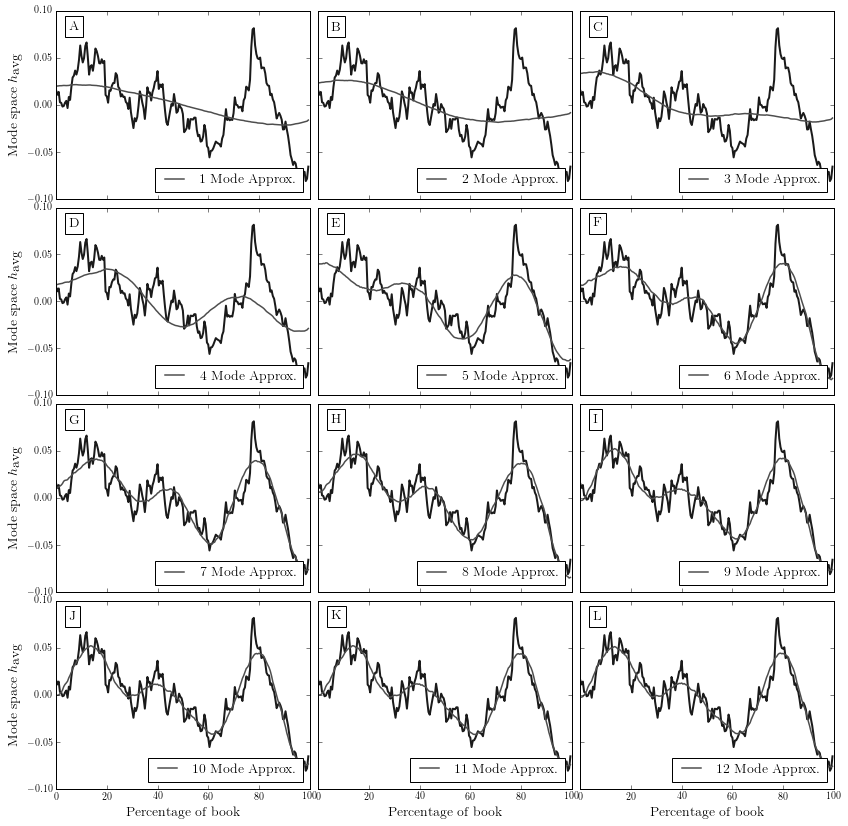

In [20]:
fig = plt.figure(figsize=(12,12))
# plt.title('12 mode reconstruction of {}'.format(b.title[:30]))

n_x = 3
n_y = 4

# whole figure label padding
xpad = .085
ypad = .085
xpadr = .015
ypadr = .015
xpadding= .01
ypadding = .01
# remaining width
xrem = 1.-xpad-xpadr
yrem = 1.-ypad-ypadr
xwidth = (xrem-(n_x-1)*xpadding)/(n_x)
ywidth = (yrem-(n_y-1)*ypadding)/(n_y)

# for i in range(istart,plotsize+1):

# b,s,i = mode_0_top_pos_norm[0]
i = 0
b = q[i]
print(b.title)
                
for k in range(1,13):
    # this is the y
    n = int(np.floor(((k-1)/n_x)))
    # this is the x
    m = (k-1)-n*n_x
    # print(m,n)
    rect = [xpad+m*(xwidth+xpadding),1-ywidth-ypadr-n*(ywidth+ypadding),xwidth,ywidth]
    ax = fig.add_axes(rect)  
    # plt.title('{} mode reconstruction of {}'.format(k,b.title[:30]))
    
    ax.plot(np.arange(0,100,0.5),big_matrix_mean0[i],color=".1",linewidth=2,label=None)
    # print(s,i,b.title)
    reconstruction = np.zeros(V[0,:].shape)
    for j in range(0,k):
        reconstruction += V[j,:]*w[i,j]
    ax.plot(np.arange(0,100,0.5),reconstruction,color=".3",linewidth=1.5,label="{0} Mode Approx.".format(k))
    if m != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r"Mode space $h_{\textnormal{avg}}$",fontsize=14)
    if n != (n_y-1):
        # print("no xlabel")
        ax.set_xticklabels([])
    else: 
        ax.set_xlabel("Percentage of book",fontsize=14)
    props = dict(boxstyle='square', facecolor='white', alpha=1.0)
    # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
    my_ylim = ax.get_ylim()
    # ax.text(.035*100, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), letters[k-1],
    ax.text(0.05, 0.95, letters[k-1],
                 fontsize=14,
                 verticalalignment='top',
                 horizontalalignment='left',
                 transform=ax.transAxes,
                 bbox=props)
    # ax.text(.05,.95,"A")
    ax.legend(loc="lower right",fontsize=14)
# plt.subplot(4,3,2)
# plt.title('12 mode reconstruction of {}'.format(b.title[:31]),fontsize=20)
mysavefig("example-timeseries-recon-stacked-{}.pdf".format(b.gutenberg_id),folder=this_dir,openfig=False)

## could put these all on the same plot (by flipping them....but the sign matters here!)

again this seems to be an issue with the SVD though.

it is finding the modes that explain the most variance using BOTH versions of the mode

...which is not what we want!! ex: man in the whole is the main story.

it will struggle to find this because it will need to explain with the negative of this!

In [21]:
num_modes = 10

core_emotional_arcs = [sorted(zip(w_normalized[i,:],
                                  range(1,len(w_normalized[i,:])+1)),
                              key=lambda x: np.abs(x[0]),
                              reverse=True) for i,b in enumerate(q)]

In [22]:
# this is the sorted, normalized mode coefficients for each book
len(core_emotional_arcs)

1385

In [23]:
# each of these is the mode coefficient, and the mode number
core_emotional_arcs[0][:10]

[(0.09959854558163718, 5),
 (-0.086182181183021914, 1),
 (-0.077984318792019336, 6),
 (-0.062712000227142323, 4),
 (-0.035997882710839306, 3),
 (0.031701473787929986, 2),
 (-0.027259636709158486, 9),
 (0.023793857933399915, 15),
 (-0.022246227041111004, 8),
 (0.020399465182296832, 7)]

In [24]:
chars = 47
# let's write a list of all books used in the study, and their attached mode
# f = open("output/mode-tables/all-books.tex","w")
# for i,b in enumerate(q):
f = open(join(this_dir,"all-books-downloads.tex"),"w")
# f.write("\\begin{table}\n")
# f.write("\\begin{tabular}{c | l | c | c | c | c | c | c}\n")
f.write("\\begin{longtable}{l | l | l | l | l | l | l | l}\n")
f.write("ID & ~Title & DL's & Mode & \\# Words & \\# Uniq & $h_{{\\textrm{{avg}}}}^{{b_i}}$ & LoCC\\\\\n")
f.write("\\hline\n")
f.write("\\endhead\n")
for i,b in sorted(enumerate(q),key=lambda x: x[1].downloads,reverse=True):
    this_mode = core_emotional_arcs[i][0][1]
    if core_emotional_arcs[i][0][0] > 0:
        flip = ""
    else:
        flip = "-"
    if len(b.title) > chars:
        b.title = b.title[:chars-3]+"..."
    tex_title = tex_escape(b.title.replace("\n",": "))
    # print(flip,this_mode)
    f.write("{0} & ~{1} & {2:,} & {3}SV{4} & {6:,} & {5:,} & {7:.2f} & {8}\\\\\n".format(b.gutenberg_id,
                                                      tex_title,
                                                      b.downloads,
                                                      flip,this_mode,
                                                      b.numUniqWords,
                                                      b.length,
                                                      data[i,:].mean(),
                                                      b.locc_string))
# f.write("\\end{tabular}\n")
# f.write("\\end{table}\n")
f.write("\\end{longtable}\n")
f.close()

In [25]:
# split onto the positive and negative of each mode
pos_stories = [[] for i in range(len(core_emotional_arcs[0]))]
neg_stories = [[] for i in range(len(core_emotional_arcs[0]))]

for i in range(len(core_emotional_arcs)):
    if core_emotional_arcs[i][0][0] > 0:
        pos_stories[core_emotional_arcs[i][0][1]-1].append(i)
    else:
        neg_stories[core_emotional_arcs[i][0][1]-1].append(i)
print(pos_stories[0][:10])
print(neg_stories[0][:10])

[25, 30, 55, 62, 67, 73, 93, 113, 117, 118]
[9, 11, 12, 18, 32, 33, 34, 36, 38, 42]


In [26]:
# check that these types work
# for any m, the first coefficient should be the biggest (and positive, from pos_stories)
m=0
print(w_normalized[pos_stories[m][0],:20])
print(w_normalized[neg_stories[m][0],:20])
print(pos_stories[0][:20])
print(len(q))

[ 0.13502497  0.06130269 -0.04999205  0.12286284 -0.07839704  0.00042705
 -0.0240887   0.00299937 -0.00714099  0.0312066   0.01051325  0.01385147
 -0.01534782 -0.00153308  0.00054042  0.00612179  0.00904404  0.0059517
 -0.00200064  0.02433671]
[-0.32127473  0.1765995   0.0104504   0.01654749 -0.04495475  0.02018331
 -0.03502815  0.00775318  0.00451921  0.021811    0.03007635  0.00064857
 -0.01207774 -0.003264   -0.01669548  0.00345316  0.00454016  0.00475898
  0.00049223 -0.00800604]
[25, 30, 55, 62, 67, 73, 93, 113, 117, 118, 127, 131, 159, 165, 166, 177, 178, 186, 188, 194]
1385


In [27]:
all_lists = [{} for i in range(num_modes)]

for m in range(num_modes):
    all_lists[m]["top_abs"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
    all_lists[m]["top_pos"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: -x[1])
    all_lists[m]["top_neg"] = sorted(zip(q,w[:,m],range(len(q))),key=lambda x: x[1])
    all_lists[m]["top_abs_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: np.abs(x[1]),reverse=True)
    all_lists[m]["top_pos_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: -x[1])
    all_lists[m]["top_neg_norm"] = sorted(zip(q,w_normalized[:,m],range(len(q))),key=lambda x: x[1])
    q_mode = [q[i] for i in pos_stories[m]]
    all_lists[m]["top_pos_norm_attached"] = sorted(zip(q_mode,
                                                       w_normalized[pos_stories[m],m],
                                                       pos_stories[m]),
                                                   key=lambda x: x[1],
                                                   reverse=True)
    all_lists[m]["top_pos_norm_attached_downloads"] = sorted(zip(q_mode,
                                                                 w_normalized[pos_stories[m],m],
                                                                 pos_stories[m]),
                                                             key=lambda x: x[0].downloads,
                                                             reverse=True)
    q_mode = [q[i] for i in neg_stories[m]]
    all_lists[m]["top_neg_norm_attached"] = sorted(zip(q_mode,
                                                       w_normalized[neg_stories[m],m],
                                                       neg_stories[m]),
                                                   key=lambda x: x[1])
    all_lists[m]["top_neg_norm_attached_downloads"] = sorted(zip(q_mode,
                                                                 w_normalized[neg_stories[m],m],
                                                                 neg_stories[m]),
                                                             key=lambda x: x[0].downloads,
                                                             reverse=True)                                                      

In [28]:
g = open(join(this_dir,"core-stories-nonempty-inputs.tex"),"w")
for mode in range(10):
    mode_num = mode*2+1
    if len(all_lists[mode]["top_pos_norm_attached"]) > 0:
        g.write("\\input{{../../output/mode-tables/core-stories-{0:02d}}}\n\\input{{../../output/mode-tables/core-stories-{0:02d}-downloads}}\n".format(mode_num))
    f = open(join(this_dir,"core-stories-{:02d}.tex".format(mode_num)),"w")
    f.write("\\begin{longtable}{l | l | l | l | c}\n")
    f.write("ID & ~Title & DL's & max($W$[i,:]) & Arc\\\\\n")
    f.write("\\hline\n")
    f.write("\\endhead\n")
    for b,s,i in all_lists[mode]["top_pos_norm_attached"]:
        tex_title = tex_escape(b.title.replace("\n",": "))
        f.write("{0} & ~{1} & {2:,} & {3:.4f} & \\adjustimage{{height=12px,width=45px,valign=m}}{{/Users/andyreagan/projects/2014/09-books/media/figures/all-timeseries/{0}.pdf}} \\\\\n".format(b.gutenberg_id,
                                                          tex_title,
                                                          b.downloads,
                                                          s))
    # f.write("\\end{tabular}\n")
    # f.write("\\end{table}\n")
    f.write("\\caption{{Stories which are are represented by core emotional arc {0}, sorted by the variance explained in their emotional arc by core emotional arc {0}.}}\n".format(mode_num))
    f.write("\\end{longtable}\n")
    f.close()
    f = open(join(this_dir,"core-stories-{:02d}-downloads.tex".format(mode_num)),"w")
    f.write("\\begin{longtable}{l | l | l | l  | c}\n")
    f.write("ID & ~Title & DL's & max(W[i,:]) & Arc\\\\\n")
    f.write("\\hline\n")
    f.write("\\endhead\n")
    for b,s,i in all_lists[mode]["top_pos_norm_attached_downloads"]:
        tex_title = tex_escape(b.title.replace("\n",": "))
        f.write("{0} & ~{1} & {2:,} & {3:.4f} & \\adjustimage{{height=12px,width=45px,valign=m}}{{/Users/andyreagan/projects/2014/09-books/media/figures/all-timeseries/{0}.pdf}} \\\\\n".format(b.gutenberg_id,
                                                          tex_title,
                                                          b.downloads,
                                                          s))
    # f.write("\\end{tabular}\n")
    # f.write("\\end{table}\n")
    f.write("\\caption{{Stories which are are represented by core emotional arc {0}, sorted by downloads.}}\n".format(mode_num))
    f.write("\\end{longtable}\n")
    f.close()
    mode_num = mode*2+2
    if len(all_lists[mode]["top_neg_norm_attached"]) > 0:
        g.write("\\input{{../../output/mode-tables/core-stories-{0:02d}}}\n\\input{{../../output/mode-tables/core-stories-{0:02d}-downloads}}\n".format(mode_num))

    f = open(join(this_dir,"core-stories-{:02d}.tex".format(mode_num)),"w")
    f.write("\\begin{longtable}{l | l | l | l | c}\n")
    f.write("ID & ~Title & DL's & max($W$[i,:]) & Arc\\\\\n")
    f.write("\\hline\n")
    f.write("\\endhead\n")
    for b,s,i in all_lists[mode]["top_neg_norm_attached"]:
        tex_title = tex_escape(b.title.replace("\n",": "))
        f.write("{0} & ~{1} & {2:,} & {3:.4f} & \\adjustimage{{height=12px,width=45px,valign=m}}{{/Users/andyreagan/projects/2014/09-books/media/figures/all-timeseries/{0}.pdf}} \\\\\n".format(b.gutenberg_id,
                                                          tex_title,
                                                          b.downloads,
                                                          abs(s)))
    # f.write("\\end{tabular}\n")
    # f.write("\\end{table}\n")
    f.write("\\caption{{Stories which are are represented by core emotional arc {0}, sorted by the variance explained in their emotional arc by core emotional arc {0}.}}\n".format(mode_num))
    f.write("\\end{longtable}\n")
    f.close()
    f = open(join(this_dir,"core-stories-{:02d}-downloads.tex".format(mode_num)),"w")
    f.write("\\begin{longtable}{l | l | l | l | c}\n")
    f.write("ID & ~Title & DL's & max($W$[i,:]) & Arc\\\\\n")
    f.write("ID & ~Title & DL's & max(W[i,:])\\\\\n")
    f.write("\\hline\n")
    f.write("\\endhead\n")
    for b,s,i in all_lists[mode]["top_neg_norm_attached_downloads"]:
        tex_title = tex_escape(b.title.replace("\n",": "))
        f.write("{0} & ~{1} & {2:,} & {3:.4f} & \\adjustimage{{height=12px,width=45px,valign=m}}{{/Users/andyreagan/projects/2014/09-books/media/figures/all-timeseries/{0}.pdf}} \\\\\n".format(b.gutenberg_id,
                                                          tex_title,
                                                          b.downloads,
                                                          abs(s)))
    # f.write("\\end{tabular}\n")
    # f.write("\\end{table}\n")
    f.write("\\caption{{Stories which are are represented by core emotional arc {0}, sorted by downloads.}}\n".format(mode_num))
    f.write("\\end{longtable}\n")
    f.close()
g.close()

xwidth is 0.29
0
[-0.20000000000000001, -0.15000000000000002, -0.10000000000000001, -0.049999999999999989, 0.0, 0.049999999999999989, 0.10000000000000003, 0.15000000000000002, 0.20000000000000001, 0.25]
1
2
xwidth is 0.29
0
[-0.20000000000000001, -0.15000000000000002, -0.10000000000000001, -0.049999999999999989, 0.0, 0.049999999999999989, 0.10000000000000003, 0.15000000000000002, 0.20000000000000001, 0.25]
1
2
xwidth is 0.29
0
[-0.40000000000000002, -0.30000000000000004, -0.20000000000000001, -0.099999999999999978, 0.0, 0.099999999999999978, 0.20000000000000007, 0.30000000000000004, 0.40000000000000002, 0.5]
1
2
xwidth is 0.29
0
[-0.40000000000000002, -0.30000000000000004, -0.20000000000000001, -0.099999999999999978, 0.0, 0.099999999999999978, 0.20000000000000007, 0.30000000000000004, 0.40000000000000002, 0.5]
1
2


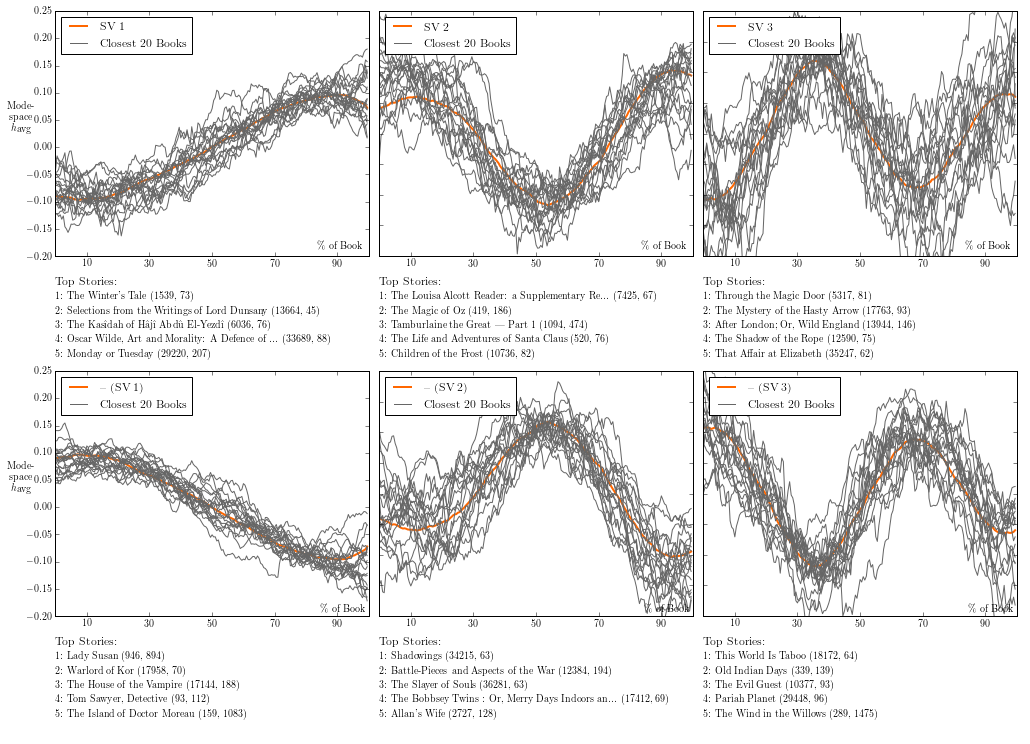

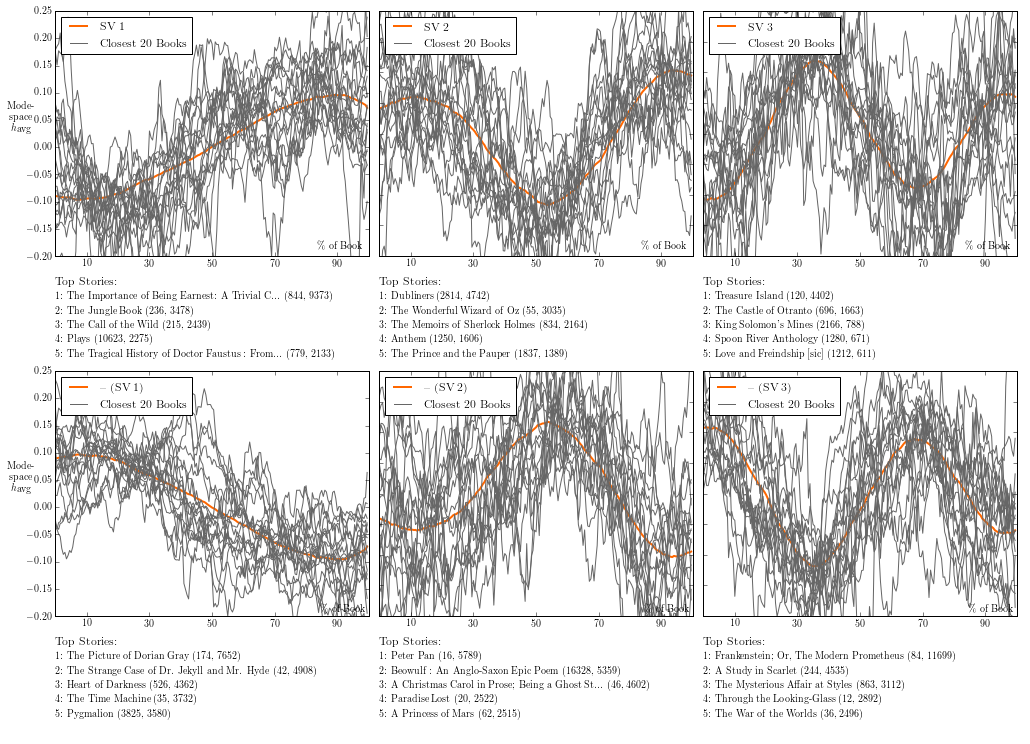

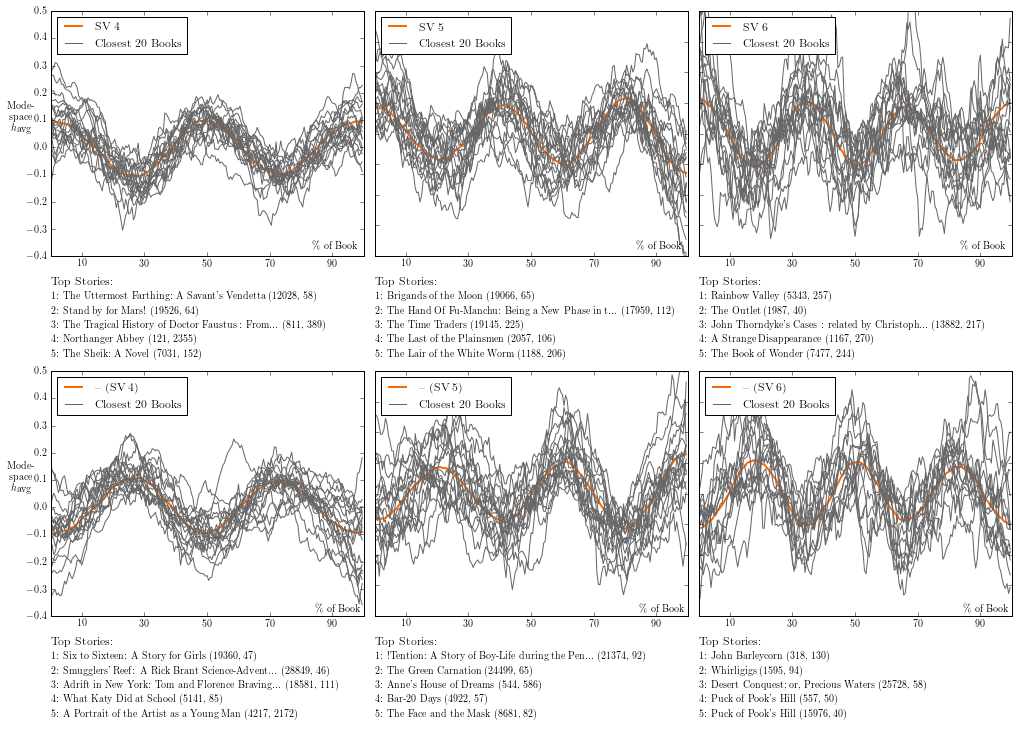

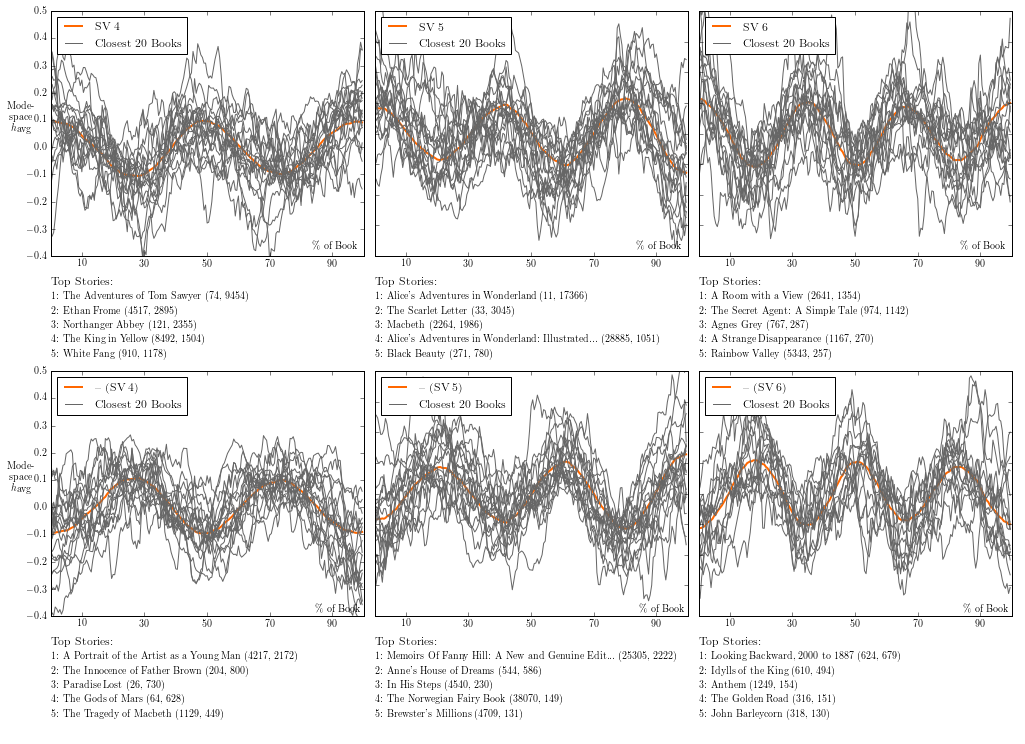

In [29]:
def plot_svs(svstart,v=True,fix_ylim=0.0,xspacing=.01,keys=["top_pos_norm","top_neg_norm"],postfix=""):
    nsvs = 3
    xoffset = .1
    xwidth = (1.-xoffset)/(nsvs)-xspacing
    print('xwidth is {0}'.format(xwidth))
    
    chars = 47
    
    fig = plt.figure(figsize=(15,10))
    for sv in range(0,3):
        print(sv)
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+sv*(xspacing+xwidth),.65,xwidth,.34]
        ax1 = fig.add_axes(ax1rect)
        ax1books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.5,xwidth,.1])
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
        ax1.plot(np.arange(0,100,0.5),V[sv+svstart,:],color="#ff6700",linewidth=2,label="SV {}".format(sv+svstart+1))
        j=0
        for b,s,i in all_lists[sv+svstart][keys[0]][:20]:
            if j == 0:
                ax1.plot(np.arange(0,100,0.5),big_matrix_mean0[i]/w[i,sv+svstart],color=".4",label="Closest 20 Books")
            else:
                ax1.plot(np.arange(0,100,0.5),big_matrix_mean0[i]/w[i,sv+svstart],color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    b.title = b.title[:chars-3]+"..."
                this_string = '{0}: {1} ({2}, {3})'.format(j+1,
                                                           b.title.replace("\n",": "),
                                                           b.gutenberg_id,
                                                           b.downloads)
                tex_string = tex_escape(this_string)
                ax1books.text(0.0,.9-j*.2,tex_string,fontsize=10)
            j+=1
            # print(b.exclude)
        
        # ax1.set_xticklabels([])
        # ax1.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        ax1.set_xticks([10,30,50,70,90])
        ax1.set_xticklabels(["10","30","50","70","90"])
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ {\normalsize Percentage of book}")
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ ~~~~~ ~~~~~")
        ax1.text(.98,0.02,r"\% of Book",ha="right",va="bottom",transform=ax1.transAxes)
        ax1books.text(0.0,1.1,"Top Stories:",fontsize=12)
        ax1.legend(loc="upper left")

        #ax1.axis('off')
        ax1books.axis('off')

        ax2 = fig.add_axes([xoffset+sv*(xspacing+xwidth),.15,xwidth,.34])
        ax2books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.0,xwidth,.10])
        # ax2.set_title('20 closest negative correlates')
        if v:
            print('-'*80)
            print('20 closest negative correlates:')
        ax2.plot(np.arange(0,100,0.5),-V[sv+svstart,:],color="#ff6700",linewidth=2,label="-- (SV {})".format(sv+svstart+1))
        j=0
        for b,s,i in all_lists[sv+svstart][keys[1]][:20]:
            if j == 0:
                ax2.plot(np.arange(0,100,0.5),-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label="Closest 20 Books")
            else:
                ax2.plot(np.arange(0,100,0.5),-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    b.title = b.title[:chars-3]+"..."
                this_string = '{0}: {1} ({2}, {3})'.format(j+1,
                                                           b.title.replace("\n",": "),
                                                           b.gutenberg_id,
                                                           b.downloads)
                tex_string = tex_escape(this_string)
                ax2books.text(0.0,.9-j*.2,tex_string,fontsize=10)
            j+=1
            # print(b.exclude)
        
        # ax2.set_xticklabels([])
        # ax2.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ {\normalsize Percentage of book}")
        ax2.legend(loc="upper left")
        
        # ax2.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        # ax2.set_xticklabels(["0","20","40","60","",""])
        ax2books.text(0.0,1.1,"Top Stories:",fontsize=12)
        
        ax2.set_xticks([10,30,50,70,90])
        ax2.set_xticklabels(["10","30","50","70","90"])
        ax2.text(.99,0.01,r"\% of Book",ha="right",va="bottom",transform=ax2.transAxes)
        
        
        #ax1.axis('off')
        ax2books.axis('off')
        
        if fix_ylim > 0:
            ax1.set_ylim([-fix_ylim,fix_ylim])
            ax2.set_ylim([-fix_ylim,fix_ylim])
        if sv > 0:
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])
        else:
            new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
            ax1.set_yticks(new_ticks)
            ax2.set_yticks(new_ticks)
            print(new_ticks)
            # new_ticks[new_ticks.index(0.0)] = "Happs"
            new_ticks[new_ticks.index(0.0)] = r"""Mode-
space
$h_{\textnormal{avg}}$"""
            
            # ax1.set_yticklabels(new_ticks)
            # ax2.set_yticklabels(new_ticks)
            ax1.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            ax2.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            
            
    # mysavefig('SV{0}.svg'.format('4-6'))
    # mysavefig("SVD-timeseries-mode-{}-{}.png".format(svstart+1,svstart+4),folder="media/figures/SVD",openfig=False)
    mysavefig("SVD-timeseries-mode-{}-{}{}.pdf".format(svstart+1,svstart+4,postfix),folder=this_dir,openfig=True)
plot_svs(0,v=False,fix_ylim=.2,keys=["top_pos_norm_attached","top_neg_norm_attached"])
plot_svs(0,v=False,fix_ylim=.2,keys=["top_pos_norm_attached_downloads","top_neg_norm_attached_downloads"],postfix="-downloads")
plot_svs(3,v=False,fix_ylim=.4,keys=["top_pos_norm_attached","top_neg_norm_attached"])
plot_svs(3,v=False,fix_ylim=.4,keys=["top_pos_norm_attached_downloads","top_neg_norm_attached_downloads"],postfix="-downloads")

the previous analysis took the stories which are closest to the core emotional arcs

but, a story could have been the closest to two different arcs (although very unlikely) with
coefficients that are large for two modes, and 0 for the rest.



so, we need to actually figure out the main core emotional arc for each story

do this by considering the absolute value of the coeff, but keep track of whether it was pos or neg



1 for SV 1, and -1 for -SV 1.

2 for SV 2, and -2 for -SV 2.

In [30]:
core_emotional_arcs = [sorted(zip(w_normalized[i,:],
                                  range(1,len(w_normalized[i,:])+1)),
                              key=lambda x: np.abs(x[0]),
                              reverse=True) for i,b in enumerate(q)]
all_downloads = [b.downloads for b in q]

In [31]:
def core_stats(book_indices):
    N = len(book_indices)
    percentage = N/len(q)*100
    these_downloads = [q[i].downloads for i in book_indices]
    percentage_more = np.sum(these_downloads>np.mean(all_downloads))/len(these_downloads)*100
    return N,percentage,np.mean(these_downloads),np.median(these_downloads),these_downloads,np.var(these_downloads),percentage_more
def find_bin_i(bins,x):
    j = 0
    while bins[j] < x:
        j+=1
    return j-1

In [32]:
for i in range(15):
    stats = core_stats(pos_stories[i])
    print("SV {}".format(i+1),stats[:4])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    # ax.set_xlim([100,1000])
    # ax.hist(stats[4],bins=np.arange(100,20000,100),color=".5")
    # ax.hist(stats[4],color=".5")
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    # ax.set_xlim([100,20000])
    ax.axis("off")
    mysavefig("SV{0}-+-sparkhist.pdf".format(i+1),folder=this_dir,date_prefix=False,openfig=False,pdfcrop=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100,0.5),V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
    mysavefig("SV{0}-+-spark.pdf".format(i+1),folder=this_dir,date_prefix=False,openfig=False,pdfcrop=True)
    plt.close(fig)
    stats = core_stats(neg_stories[i])
    print("-SV {}".format(i+1),stats[:4])
    fig = plt.figure(figsize=(6,.55))
    ax = fig.add_axes([0,0,1,1])
    a = ax.hist(np.log10(stats[4]),bins=np.arange(2.0,4.5,.07),color=".5")
    ax.plot([2.0,4.5],[0.0,0.0],linewidth=0.5,color=".7")
    ax.set_xlim([2.0,4.5])
    y_range = ax.get_ylim()[1]
    ax.plot(np.log10(stats[3]),a[0][find_bin_i(a[1],np.log10(stats[3]))]+y_range*.17,'kv',markersize=13)
    ax.plot(np.log10(stats[2]),a[0][find_bin_i(a[1],np.log10(stats[2]))]+y_range*.17,'kv',markersize=13,fillstyle='none')
    ax.axis("off")
    mysavefig("SV{0}---sparkhist.pdf".format(i+1),folder=this_dir,date_prefix=False,openfig=False,pdfcrop=True)
    plt.close(fig)
    fig = plt.figure(figsize=(1.5,.55))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(np.arange(0,100,0.5),-V[i,:],color="#ff6700",linewidth=2)
    ax.axis("off")
    mysavefig("SV{0}---spark.pdf".format(i+1),folder=this_dir,date_prefix=False,openfig=False,pdfcrop=True)
    plt.close(fig)

SV 1 (148, 10.68592057761733, 294.0, 78.0)
-SV 1 (431, 31.11913357400722, 238.7262180974478, 83.0)
SV 2 (152, 10.974729241877256, 228.92105263157896, 76.5)
-SV 2 (178, 12.851985559566787, 302.92134831460675, 96.5)
SV 3 (74, 5.342960288808665, 219.94594594594594, 91.0)
-SV 3 (140, 10.108303249097473, 377.37857142857143, 93.5)
SV 4 (64, 4.620938628158845, 418.6875, 104.0)
-SV 4 (53, 3.8267148014440435, 195.18867924528303, 89.0)
SV 5 (47, 3.393501805054152, 628.87234042553189, 94.0)
-SV 5 (26, 1.8772563176895307, 187.5, 83.0)
SV 6 (18, 1.2996389891696751, 271.05555555555554, 128.0)
-SV 6 (16, 1.1552346570397112, 151.0625, 87.5)
SV 7 (11, 0.7942238267148014, 98.727272727272734, 89.0)
-SV 7 (16, 1.1552346570397112, 333.0, 138.0)
SV 8 (2, 0.1444043321299639, 75.5, 75.5)
-SV 8

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in long_scalars


/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)

  warnings.warn("Mean of empty slice.", RuntimeWarning)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

  ret = ret.dtype.type(ret / rcount)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)

  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/p

 (5, 0.36101083032490977, 85.0, 58.0)
SV 9 (0, 0.0, nan, nan)
-SV 9 (2, 0.1444043321299639, 282.0, 282.0)
SV 10 (0, 0.0, nan, nan)
-SV 10 (1, 0.07220216606498195, 46.0, 46.0)
SV 11 (0, 0.0, nan, nan)
-SV 11 (0, 0.0, nan, nan)
SV 12 (0, 0.0, nan, nan)
-SV 12 (1, 0.07220216606498195, 61.0, 61.0)
SV 13 (0, 0.0, nan, nan)
-SV 13 (0, 0.0, nan, nan)
SV 14 (0, 0.0, nan, nan)
-SV 14 (0, 0.0, nan, nan)
SV 15 (0, 0.0, nan, nan)
-SV 15 (0, 0.0, nan, nan)


In [33]:
threshold = ".5"
for threshold in [".5","2.5"]:
    threshold_float = float(threshold)
    threshold_string = threshold.replace(".","point")
    table_file = join(this_dir,"SVD-table-{}.tex".format(threshold_string))
    f = open(table_file,"w")
    f.write(r"""\begin{tabular}{c | c | c | c | c | c | c | c | c}
    Mode & Mode Arc & $N_m$ & $N_m/N$ & DL Median $\blacktriangledown$ & DL Mean $\triangledown$ & DL Variance & \% $>$ Average & Download Distribution \\
    \hline
    """)
    for i in range(10):
        stats = core_stats(pos_stories[i])
        if stats[1] > threshold_float:
            # print("SV {}".format(i+1),stats[:4])
            sparkfile = join(this_dir,"SV{0}-+-spark.pdf".format(i+1))
            f.write(r"SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{{1}}} & {2} & {3:.1f}\%".format(i+1,sparkfile,stats[0],stats[1]))
            f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
            sparkfile = join(this_dir,"SV{0}-+-sparkhist.pdf".format(i+1))
            f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{{0}}} \\".format(sparkfile))
            f.write("\n")
        stats = core_stats(neg_stories[i])
        if stats[1] > threshold_float:
            # print("-SV {}".format(i+1),stats[:4])
            sparkfile = join(this_dir,"SV{0}---spark.pdf".format(i+1))
            f.write(r"- SV {0} & \adjustimage{{height=12px,width=45px,valign=m}}{{{1}}} & {2} & {3:.1f}\%".format(i+1,sparkfile,stats[0],stats[1]))
            f.write(r" & {2:.1f} & {1:.1f} & {3:.0f} & {4:.1f}\%".format(i+1,stats[2],stats[3],stats[5],stats[6]))
            sparkfile = join(this_dir,"SV{0}---sparkhist.pdf".format(i+1))
            f.write(r" & \adjustimage{{height=13px,width=110px,valign=m}}{{{0}}} \\".format(sparkfile))
            f.write("\n")
    f.write(r"\end{tabular}")
    f.close()
    print(table_file)
    tabletex_file_to_pdf(table_file)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in long_scalars


/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)

  warnings.warn("Mean of empty slice.", RuntimeWarning)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

  ret = ret.dtype.type(ret / rcount)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)

  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)

/Users/andyreagan/projects/2014/09-books/pyvenv/lib/p

../media/figures/SVD/P-20K-100K-40dl-200pt/SVD-table-point5.tex
../media/figures/SVD/P-20K-100K-40dl-200pt/SVD-table-2point5.tex


xwidth is 0.29
0
[-0.20000000000000001, -0.15000000000000002, -0.10000000000000001, -0.049999999999999989, 0.0, 0.049999999999999989, 0.10000000000000003, 0.15000000000000002, 0.20000000000000001, 0.25]
1
2
xwidth is 0.29
0
[-0.40000000000000002, -0.30000000000000004, -0.20000000000000001, -0.099999999999999978, 0.0, 0.099999999999999978, 0.20000000000000007, 0.30000000000000004, 0.40000000000000002, 0.5]
1
2


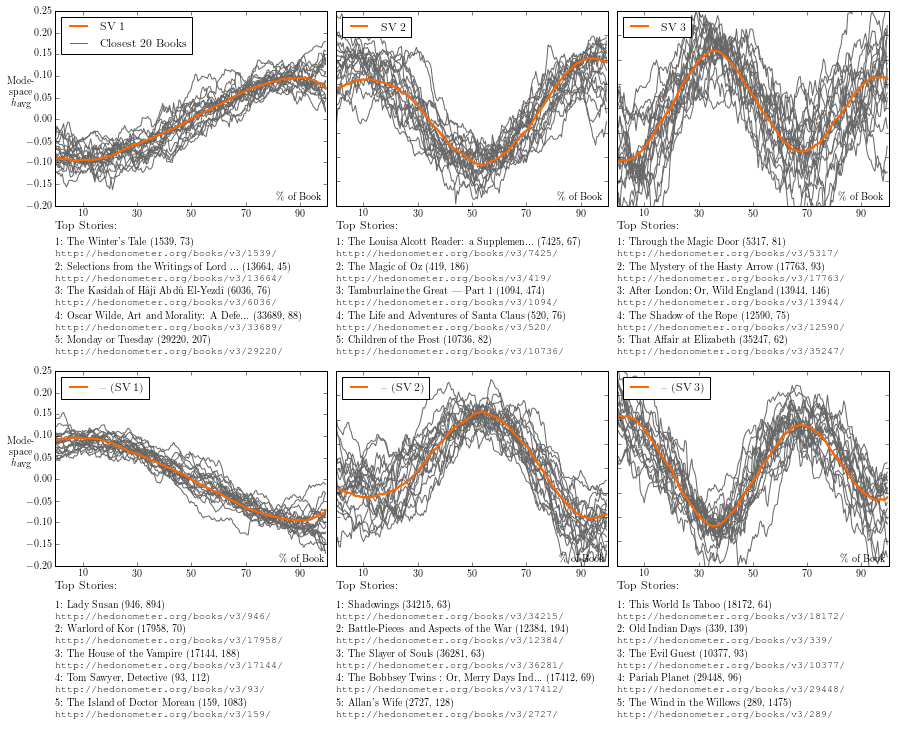

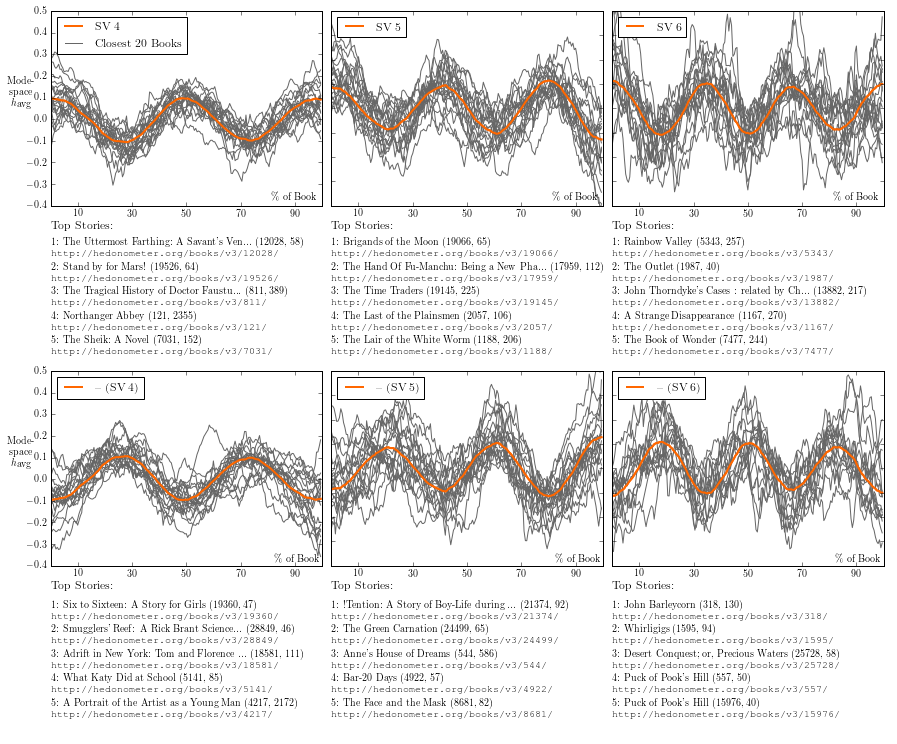

In [34]:
def plot_svs_links(svstart,v=True,fix_ylim=0.0,xspacing=.01,keys=["top_pos_norm","top_neg_norm"]):
    nsvs = 3
    xoffset = .1
    xwidth = (1.-xoffset)/(nsvs)-xspacing
    print('xwidth is {0}'.format(xwidth))
    
    chars = 40
    lineheight = .10
    
    fig = plt.figure(figsize=(13,10))
    for sv in range(0,3):
        print(sv)
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+sv*(xspacing+xwidth),.72,xwidth,.27]
        ax1 = fig.add_axes(ax1rect)
        ax1books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.5,xwidth,.17])
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
        ax1.plot(np.arange(0,100,0.5),V[sv+svstart,:],color="#ff6700",linewidth=2,label="SV {}".format(sv+svstart+1))
        j=0
        for b,s,i in all_lists[sv+svstart][keys[0]][:20]:
            if j==0 and sv == 0:
                ax1.plot(np.arange(0,100,0.5),big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label="Closest 20 Books")
            else:
                ax1.plot(np.arange(0,100,0.5),big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    # ax1books.text(0.0,.9-j*.2,'\\href{{http://gutenberg.org/ebooks/{2}}}{{{0}: {1}... ({2}, {3})}}'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax1books.text(0.0,.97-(2*j)*lineheight,'{0}: {1}... ({2}, {3})'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax1books.text(0.0,.97-(2*j+.9)*lineheight,r'\url{{http://hedonometer.org/books/v3/{0}/}}'.format(b.gutenberg_id),fontsize=10)
                else:
                    ax1books.text(0.0,.97-(2*j)*lineheight,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax1books.text(0.0,.97-(2*j+.9)*lineheight,r'\url{{http://hedonometer.org/books/v3/{0}/}}'.format(b.gutenberg_id),fontsize=10)
                    # ax1books.text(0.0,.9-j*.2,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                j+=1
            # print(b.exclude)
        ax1.plot(np.arange(0,100,0.5),V[sv+svstart,:],color="#ff6700",linewidth=2,label=None)
        # ax1.set_xticklabels([])
        # ax1.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        ax1.set_xticks([10,30,50,70,90])
        ax1.set_xticklabels(["10","30","50","70","90"])
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ {\normalsize Percentage of book}")
        # ax1.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~  ~~~~~ ~~~~~ ~~~~~")
        ax1.text(.98,0.02,r"\% of Book",ha="right",va="bottom",transform=ax1.transAxes)
        ax1books.text(0.0,1.1,"Top Stories:",fontsize=12)
        ax1.legend(loc="upper left")

        #ax1.axis('off')
        ax1books.axis('off')

        ax2 = fig.add_axes([xoffset+sv*(xspacing+xwidth),.22,xwidth,.27])
        ax2books = fig.add_axes([xoffset+sv*(xspacing+xwidth),.0,xwidth,.17])
        # ax2.set_title('20 closest negative correlates')
        if v:
            print('-'*80)
            print('20 closest negative correlates:')
        j=0
        ax2.plot(np.arange(0,100,0.5),-V[sv+svstart,:],color="#ff6700",linewidth=2,label="-- (SV {})".format(sv+svstart+1))
        for b,s,i in all_lists[sv+svstart][keys[1]][:20]:
            if j==0 and sv == 0 and False:
                ax2.plot(np.arange(0,100,0.5),-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label="Closest 20 Books")
            else:
                ax2.plot(np.arange(0,100,0.5),-big_matrix_mean0[i]/np.sum(np.abs(w[i,:]))/s,color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(s,b.title)
            if j<5 and not b.exclude:
                if len(b.title) > chars:
                    # ax1books.text(0.0,.9-j*.2,'\\href{{http://gutenberg.org/ebooks/{2}}}{{{0}: {1}... ({2}, {3})}}'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax2books.text(0.0,.95-(2*j)*lineheight,'{0}: {1}... ({2}, {3})'.format(j+1,b.title[:chars-3].replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax2books.text(0.0,.95-(2*j+.9)*lineheight,r'\url{{http://hedonometer.org/books/v3/{0}/}}'.format(b.gutenberg_id),fontsize=10)
                else:
                    ax2books.text(0.0,.95-(2*j)*lineheight,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                    ax2books.text(0.0,.95-(2*j+.9)*lineheight,r'\url{{http://hedonometer.org/books/v3/{0}/}}'.format(b.gutenberg_id),fontsize=10)
                    # ax1books.text(0.0,.9-j*.2,'{0}: {1} ({2}, {3})'.format(j+1,b.title.replace("\n",": "),b.gutenberg_id,b.downloads),fontsize=10)
                j+=1
            # print(b.exclude)
        ax2.plot(np.arange(0,100,0.5),-V[sv+svstart,:],color="#ff6700",linewidth=2,label=None)
        # ax2.set_xticklabels([])
        # ax2.set_xlabel(r"Top stories:~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ {\normalsize Percentage of book}")
        ax2.legend(loc="upper left")
        
        # ax2.set_xticklabels(["0","20","40","60",r"\% of Book",""])
        # ax2.set_xticklabels(["0","20","40","60","",""])
        ax2books.text(0.0,1.1,"Top Stories:",fontsize=12)
        
        ax2.set_xticks([10,30,50,70,90])
        ax2.set_xticklabels(["10","30","50","70","90"])
        ax2.text(.99,0.01,r"\% of Book",ha="right",va="bottom",transform=ax2.transAxes)
        
        
        #ax1.axis('off')
        ax2books.axis('off')
        
        if fix_ylim > 0:
            ax1.set_ylim([-fix_ylim,fix_ylim])
            ax2.set_ylim([-fix_ylim,fix_ylim])
        if sv > 0:
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])
        else:
            new_ticks = [x for x in ax1.yaxis.get_ticklocs()]
            ax1.set_yticks(new_ticks)
            ax2.set_yticks(new_ticks)
            print(new_ticks)
            # new_ticks[new_ticks.index(0.0)] = "Happs"
            new_ticks[new_ticks.index(0.0)] = r"""Mode-
space
$h_{\textnormal{avg}}$"""
            
            # ax1.set_yticklabels(new_ticks)
            # ax2.set_yticklabels(new_ticks)
            ax1.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            ax2.set_ylabel(r"""Mode-
space
$h_{\textnormal{avg}}$""",rotation=0)
            
            
    # mysavefig('SV{0}.svg'.format('4-6'))
    # mysavefig("SVD-timeseries-mode-{}-{}.png".format(svstart+1,svstart+4),folder="media/figures/SVD",openfig=False)
    mysavefig("SVD-timeseries-mode-{}-{}-links.pdf".format(svstart+1,svstart+4),folder=this_dir,openfig=True)
plot_svs_links(0,v=False,fix_ylim=.2,keys=["top_pos_norm_attached","top_neg_norm_attached"])
plot_svs_links(3,v=False,fix_ylim=.4,keys=["top_pos_norm_attached","top_neg_norm_attached"])